# Theano basicis

### Even before import

Theano is a framework for symbolic computations. Like numpy it allows to perform computations
with speed close to binary code. The killer features for Deep Learning is that:
- it is able to compile code for GPU;
- auto-differenciation.

The first thing to do working with theano is to set environment variable `THEANO_FLAGS` which holds all global theano parameters. An alternative is to have a .theanorc file, but Jupyter notebook offers a good way to set env variables.

The most commonly used flags:
- device: cpu, gpu0, gpu1, ...;
- openmp=True (for parallel execution);
- floatX: float32, float64 (controls default float type).

In [1]:
%env THEANO_FLAGS='device=gpu0','floatX=float32'

env: THEANO_FLAGS='device=gpu0','floatX=float32'


In [2]:
import theano

### most commonly used submodule
import theano.tensor as T

Using gpu device 0: GeForce GTX TITAN X (CNMeM is disabled, cuDNN 5005)


In [3]:
### and a bunch of other libraries
import numpy as np

%matplotlib nbagg
import matplotlib.pyplot as plt

Theano is about symbolic computations.
Firstly, let's define some symbolic vectors.

In [4]:
x = T.fvector('x')
y = T.fvector('y')

`z` below is just a declaration, which one can read as: values of `z` can be obtained by adding values of `x` to values of `y`. 

In [5]:
z = x + y

In [6]:
z

Elemwise{add,no_inplace}.0

Inside theano build a computational graphs that may look like this:

`x -> (+) <- y`

And `z` just a name of this tree.

To evaluate expression, one can use `eval` method.
This method is quete slow and usually uses Python implementations of all operations but quite great for
debuging since it does not require to compile anything.

In [7]:
z.eval({
    x : np.array([0.0, 1.0, 2.5],dtype='float32'),
    y : np.array([1.5, 3.0, 2.5],dtype='float32')
})

array([ 1.5,  4. ,  5. ], dtype=float32)

One usually works with compile functions. Below we compile a function that receives two arguments: x and y and returns z.

In [8]:
f = theano.function([x, y], z)

Depending on target device this function will be turned into:
- `C` code (possibly with OpenMP or/and BLAS support);
- `CUDA` code for execution on a GPU.

**Note**: while code for CPU can work directly with arguments, GPU functions will copy all arguments to the GPU device. Although, usually it is ok, it is still a potential bootleneck or at least place to optimize performance.

In [9]:
f(
    np.array([0.0, 1.0, 2.5],dtype='float32'),
    np.array([1.5, 3.0, 2.5],dtype='float32')
)

array([ 1.5,  4. ,  5. ], dtype=float32)

## Gradients

Theano packed with auto-differenciation mechanism.
However, since it is intended to be used for Neural Networks,
currently you can efficiently take a gradient of a scalar. 

In [10]:
l = T.sum(z)

In [11]:
dl_dx = theano.grad(l, x)

In [12]:
dl_dx.eval({
    x : np.array([0.0, 1.0, 2.5],dtype='float32'),
    y : np.array([1.5, 3.0, 2.5],dtype='float32')
})

array([ 1.,  1.,  1.], dtype=float32)

Since theano is symbolic gradients are computed exactly.

## Shared variables and updates

Sometimes it is much more convenient to make some parameters shared between function calls.
It can be parameters that are used in a lot of functions or simply big datasets, which is not efficient to
pass every signle function call.

In [13]:
x = theano.shared(
    np.linspace(0.0, 1.0, num=10, dtype='float32')
)

Note that shared variable is simanteniously a symbolic variable and holds some values.
One can operate with a shared variable in the same way as with a symbolic value.

Note that every operation with a shared variable produces symbolic expression.
Thus one can think of a shared variable as of a symbolic one but with values known in advance.

Another important thing is that if target device is a GPU shared variable a stored on GPU so there is no need to copy them each time making a function call. 

In [14]:
y = T.fvector('y')

In [15]:
z = T.sum(x * y)

In [16]:
### note that x is not listed as argument 
f = theano.function([y], z)

In [17]:
f(np.linspace(0.0, 1.0, num=10, dtype='float32'))

array(3.5185186862945557, dtype=float32)

In [18]:
x.set_value(np.ones(shape=10, dtype='float32'))

In [19]:
f(np.linspace(0.0, 1.0, num=10, dtype='float32'))

array(5.0, dtype=float32)

In [20]:
x.get_value()

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.], dtype=float32)

A shared variable can be updated by a values of some theano expression.

In [21]:
i = theano.shared(np.int64(0))
inc = T.iscalar('incriment')

In [22]:
### here is defined a replacement for shared variable i:
### replace values of i with i + incriment
update = {
    i: i + inc
}

`theano.function` has a special argument for updates.

In [23]:
### function that receives inc, returns i
### and increases i by inc
f = theano.function([inc], i, updates=update)

In [24]:
f(1)

array(0)

In [25]:
f(2)

array(1)

In [26]:
i.get_value()

array(3)

Note that update is performed after function call.

## Linear regression example

It is time to put knowledge above to practice.
Here we make linear regression fit via SGD.

In [27]:
### generate some data
n_points = 100
X = np.random.uniform(-1, 1, size=n_points).astype('float32')
c_real = np.random.uniform(-1, 1)
w_real = np.random.uniform(0.5, 2.0)
y = w_real * X + c_real + np.random.normal(scale=0.25, size=n_points).astype('float32')

<IPython.core.display.Javascript object>


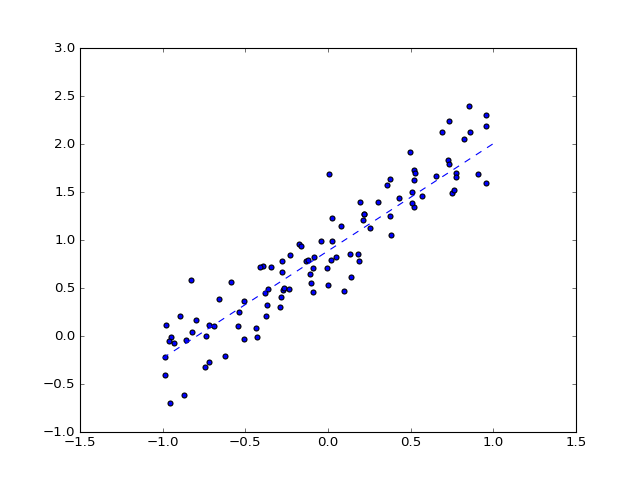

In [28]:
plt.figure()
plt.scatter(X, y)
plt.plot([-1, 1], [-w_real + c_real, w_real + c_real], '--')
plt.show()

Firstly, we define a symbolic variables that correspond to batches of X

In [29]:
X_batch = T.fvector('X_batch')
y_batch = T.fvector('y_batch')

In [30]:
w = theano.shared(np.float32(np.random.uniform(-1, 1)), name='w')
c = theano.shared(np.float32(np.random.uniform(-1, 1)), name='c')

In [31]:
y_predicted = w * X_batch + c

In [32]:
loss = T.mean((y_predicted - y_batch) ** 2)

It is time to do SGD

In [33]:
dloss_dw = theano.grad(loss, w)
dloss_dc = theano.grad(loss, c)

In [34]:
learning_rate = T.fscalar('learning rate')

In [35]:
from collections import OrderedDict

sgd_update = OrderedDict([
    (w, w - learning_rate * dloss_dw),
    (c, c - learning_rate * dloss_dc)
])

In [36]:
train = theano.function([X_batch, y_batch, learning_rate], loss, updates=sgd_update)

In [37]:
predict = theano.function([X_batch], y_predicted)

In [38]:
def batch_stream(arrays, batch_size=8):
    size = arrays[0].shape[0]
    n_batches = size / batch_size
    indx = np.random.permutation(size)

    for batch in xrange(n_batches):
        from_i = batch * batch_size
        to_i = from_i + batch_size

        batch_indx = indx[from_i:to_i]

        yield [ arr[batch_indx] for arr in arrays ]

In [39]:
from sklearn.model_selection import train_test_split

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [41]:
from mldm import NNWatcher

<IPython.core.display.Javascript object>


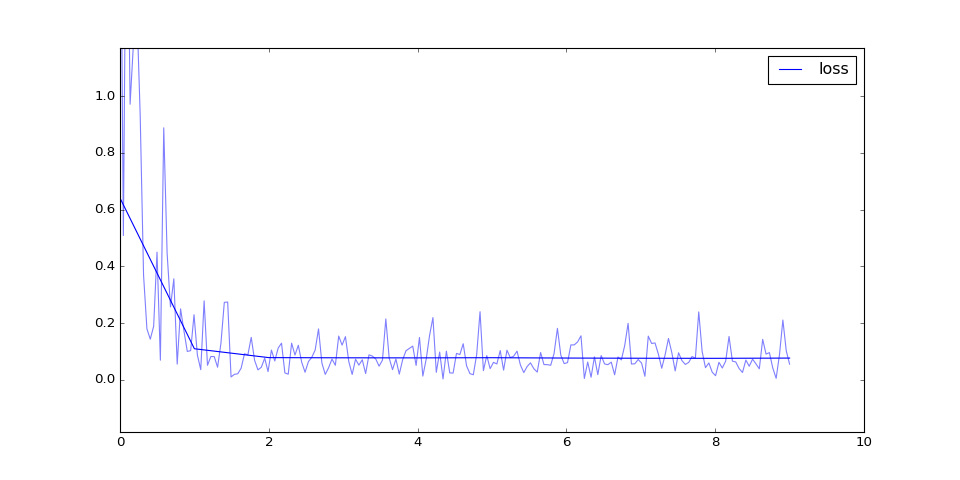

In [42]:
watcher = NNWatcher()

In [43]:
n_epoches=10
batch_size=4

history = np.zeros(shape=(n_epoches, X_train.shape[0] / batch_size), dtype='float32')

for epoch in xrange(n_epoches):
    for i, (X_b, y_b) in enumerate(batch_stream((X_train, y_train), batch_size=batch_size)):
        history[epoch, i] = train(X_b, y_b, 1.0e-1)
    
    watcher.draw(history[:(epoch + 1)])

<IPython.core.display.Javascript object>


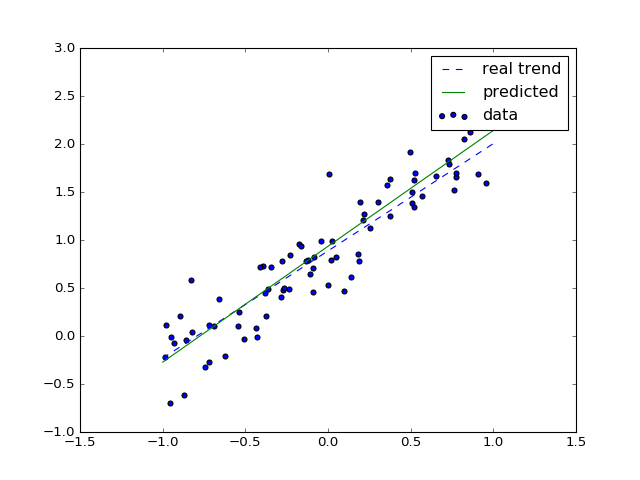

In [44]:
plt.figure()
plt.scatter(X_train, y_train, label='data')
plt.plot([-1, 1], [-w_real + c_real, w_real + c_real], '--', label='real trend')
plt.plot([-1, 1], predict(np.array([-1, 1], dtype='float32')), color='green', label='predicted')
plt.legend()
plt.show()

In [45]:
w.get_value(), c.get_value()

(array(1.2067844867706299, dtype=float32),
 array(0.9344493746757507, dtype=float32))

In [46]:
w_real, c_real

(1.117561281578843, 0.8864390378801943)

# Practice

As an exercise write logistic regression on MNIST data.
Below is some shell code to load MNIST load helper.

In [47]:
%%sh

### loading a little code snippet
wget -q -nc https://raw.githubusercontent.com/amitgroup/amitgroup/master/amitgroup/io/mnist.py

In [48]:
### http://g.sweyla.com/blog/2012/mnist-numpy/
import mnist

In [49]:
%%sh

### loads MNIST dataset into mnist folder
### if MNIST is already downloaded
### skip this

mkdir -p mnist && {
    cd mnist;
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz &&
    wget -q -nc http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz &&
    gunzip *.gz
}

gzip: t10k-images-idx3-ubyte already exists;	not overwritten
gzip: t10k-labels-idx1-ubyte already exists;	not overwritten
gzip: train-images-idx3-ubyte already exists;	not overwritten
gzip: train-labels-idx1-ubyte already exists;	not overwritten


In [50]:
X, y = mnist.load_mnist(dataset='training', path='mnist/')
X = X.reshape(-1, 1, 28, 28).astype('float32')

X_test, y_test = mnist.load_mnist(dataset='testing', path='mnist/')
X_test = X_test.reshape(-1, 1, 28, 28).astype('float32')

<IPython.core.display.Javascript object>


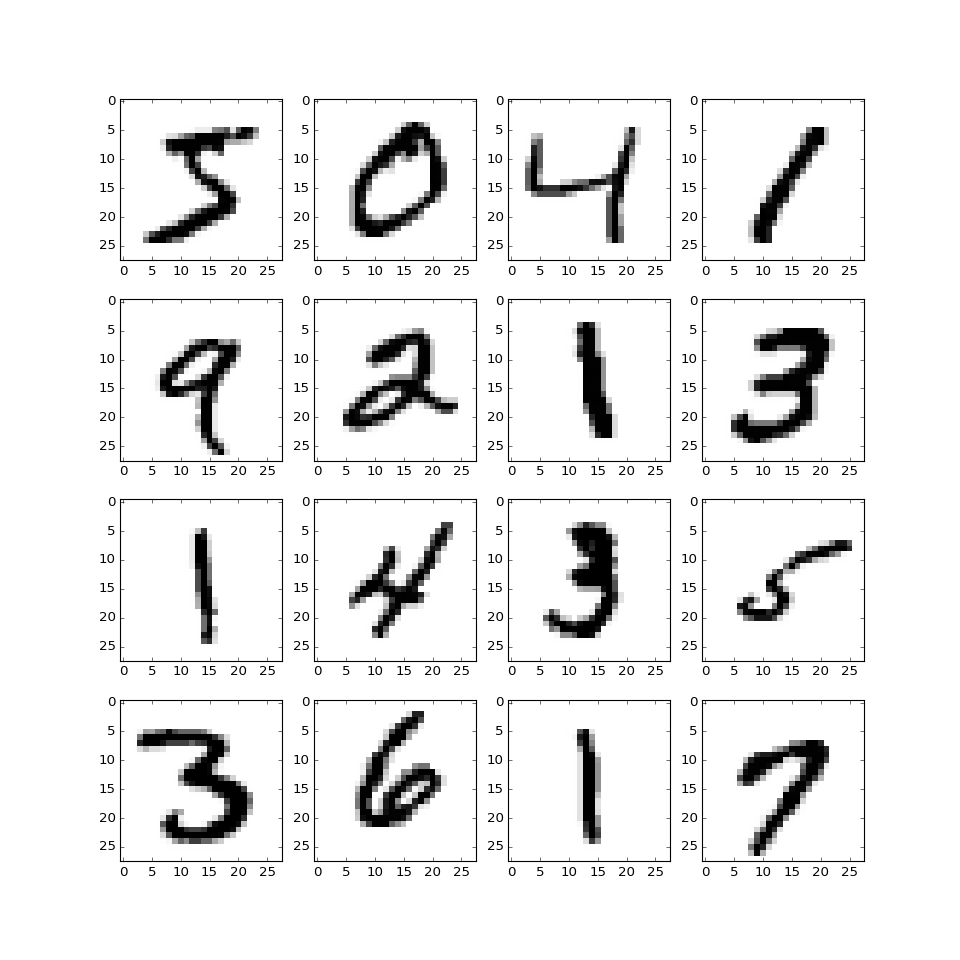

In [51]:
fig, ax = plt.subplots(4, 4, figsize=(12, 12))

for i in xrange(4):
    for j in xrange(4):
        k = i * 4 + j
        ax[i, j].imshow(X[k, 0], interpolation='none', cmap=plt.cm.gray_r)

In [52]:
X = X.reshape(-1, 28 * 28)

In [55]:
X.shape

(60000, 784)

In [76]:
def onehot(y):
    n_classes = np.max(y) + 1
    
    encoded = np.zeros(shape=(y.shape[0], n_classes), dtype='float32')
    encoded[np.arange(y.shape[0]), y] = 1
    
    return encoded

In [77]:
y = onehot(y)

/home/mborisya/opt/miniconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


IndexError: arrays used as indices must be of integer (or boolean) type

In [96]:
X_batch = T.fmatrix('X_batch')
y_batch = T.fmatrix('y_batch')

In [97]:
W = theano.shared(
    np.random.uniform(-1, 1, size=(X.shape[1], 10)).astype('float32'),
    name = 'W'
)

C = theano.shared(
    np.random.uniform(-1, 1, size=(10, )).astype('float32')
)

In [98]:
s = T.exp(X_batch.dot(W) + C[None, :])

In [99]:
ssum = T.sum(s, axis=1)

In [100]:
prediction = s / ssum[:, None]

In [101]:
loss = -T.mean(y_batch * T.log(prediction))

In [102]:
dloss_dW = theano.grad(loss, W)
dloss_dC = theano.grad(loss, C)

In [103]:
learning_rate = T.fscalar('learning rate')

In [104]:
from collections import OrderedDict

updates = OrderedDict([
    (W, W - learning_rate * dloss_dW),
    (C, C - learning_rate * dloss_dC),
])

In [105]:
train = theano.function([X_batch, y_batch, learning_rate], loss, updates=updates)

<IPython.core.display.Javascript object>


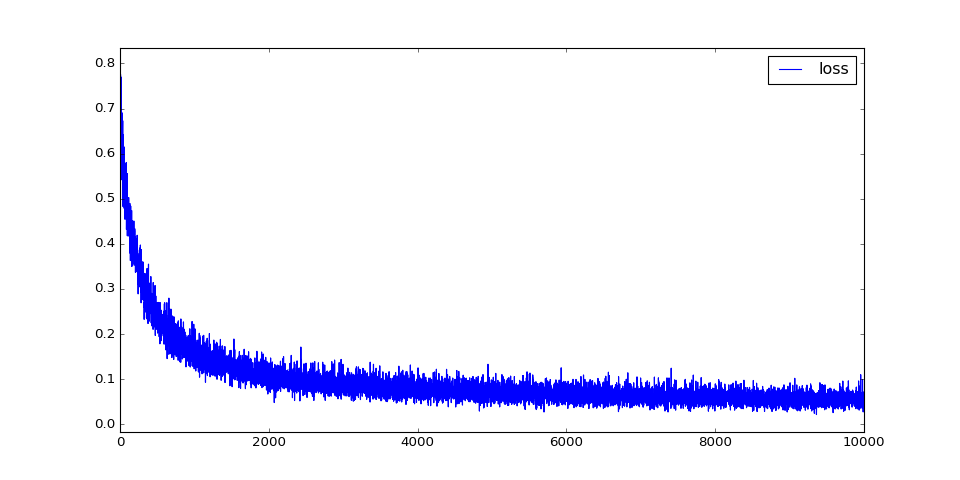

In [106]:
watcher = NNWatcher()

In [107]:
n_epoches = 10000
ls = np.zeros(shape=(n_epoches, 1))

for i in xrange(n_epoches):
    indx = np.random.choice(X.shape[0], size=128)
    
    ls[i] = train(X[indx], y[indx], 0.1)
    
    if (i + 1) % 250 == 0:
        watcher.draw(ls)

In [108]:
predict = theano.function([X_batch], prediction)

In [110]:
proba = predict(X_test.reshape(-1, 28 * 28))

In [119]:
proba[:5]

array([[  3.28602528e-06,   3.14226001e-09,   3.59065712e-06,
          5.75414269e-05,   8.71133636e-07,   9.02015074e-07,
          1.36955003e-10,   9.99675632e-01,   1.58132343e-06,
          2.56661646e-04],
       [  2.28418373e-02,   5.86206227e-07,   9.37260926e-01,
          1.46837197e-02,   2.44641598e-07,   1.86698642e-04,
          2.50100270e-02,   2.57122084e-11,   1.50535880e-05,
          9.21369406e-07],
       [  9.23312371e-07,   9.82466578e-01,   1.03336247e-03,
          7.36468751e-03,   2.95469398e-03,   1.43074038e-04,
          5.05378470e-04,   1.22358743e-03,   2.43558269e-03,
          1.87220215e-03],
       [  9.99983311e-01,   2.55064334e-13,   4.28065334e-08,
          2.99061687e-09,   1.65303752e-13,   1.63928125e-05,
          6.01350933e-08,   8.28833269e-09,   1.05743887e-07,
          6.21716234e-10],
       [  3.53468749e-06,   9.80779902e-09,   1.91347921e-04,
          2.71354497e-06,   9.93159294e-01,   1.90537485e-05,
          1.20650651e-03

In [112]:
y_predicted = np.argmax(proba, axis=1)

In [120]:
y_predicted

array([7, 2, 1, ..., 4, 5, 6])

In [114]:
np.mean(y_predicted == y_test) 

0.85070000000000001

In [115]:
w_ = W.get_value()

In [116]:
w_.shape

(784, 10)

<IPython.core.display.Javascript object>


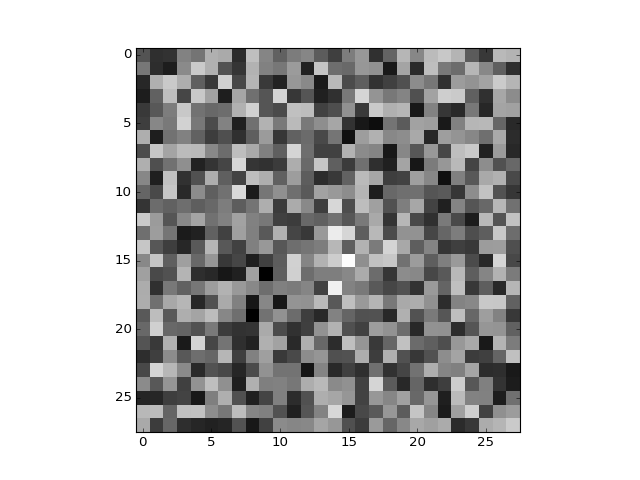

<IPython.core.display.Javascript object>


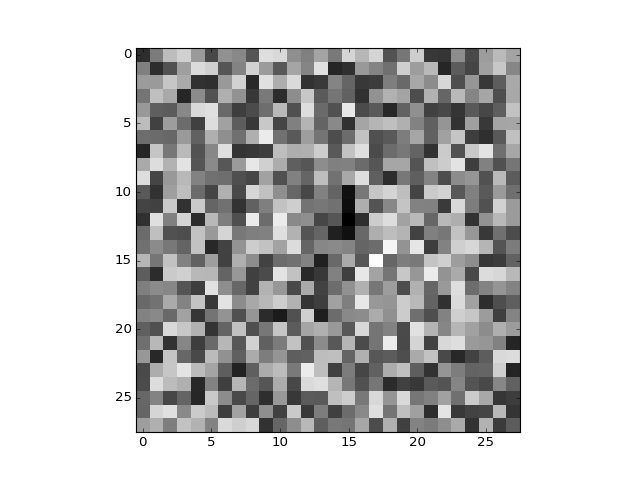

<IPython.core.display.Javascript object>


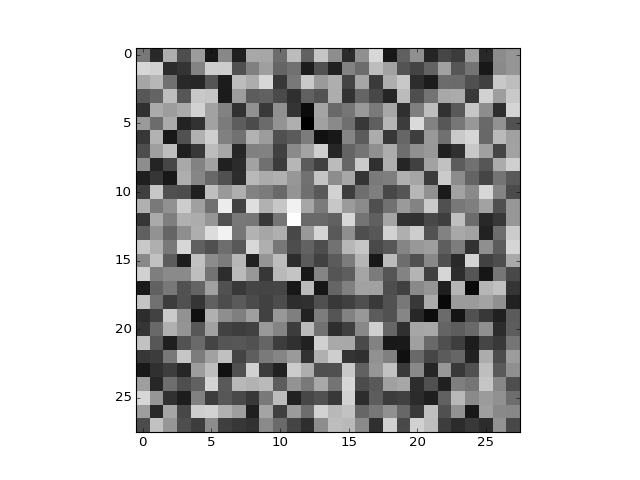

<IPython.core.display.Javascript object>


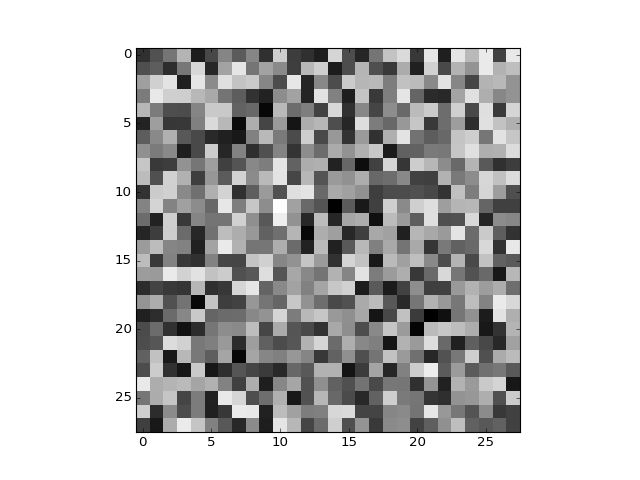

<IPython.core.display.Javascript object>


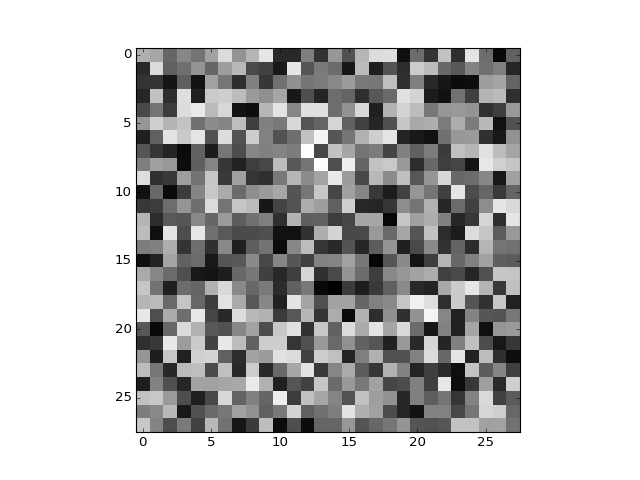

<IPython.core.display.Javascript object>


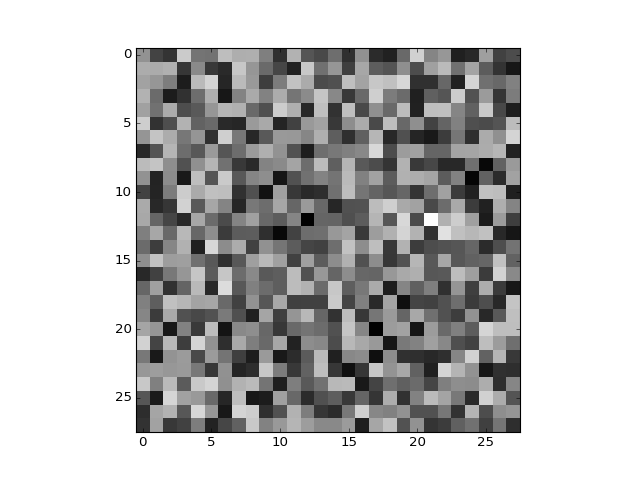

<IPython.core.display.Javascript object>


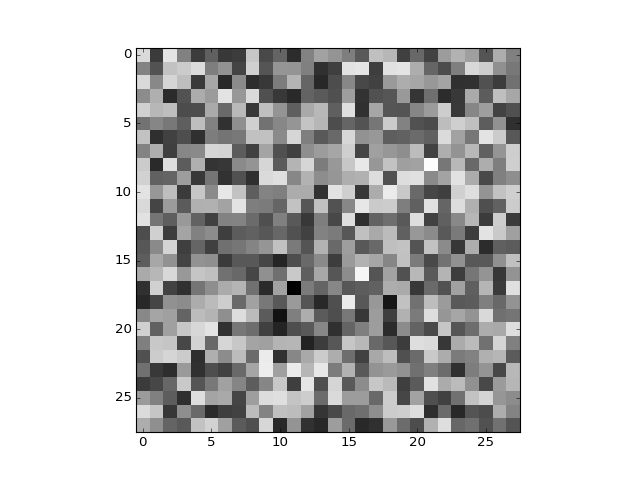

<IPython.core.display.Javascript object>


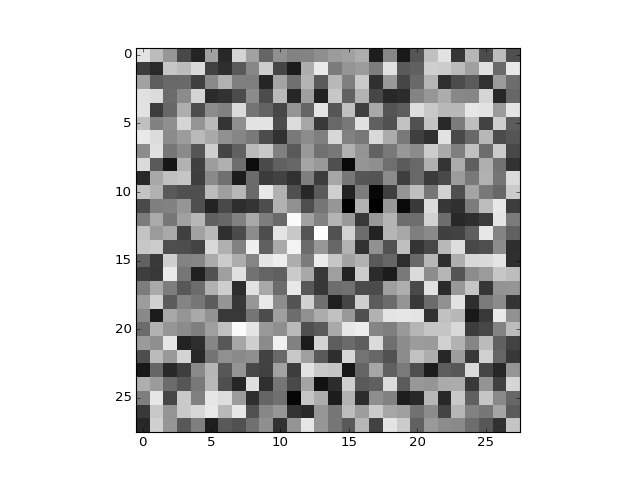

<IPython.core.display.Javascript object>


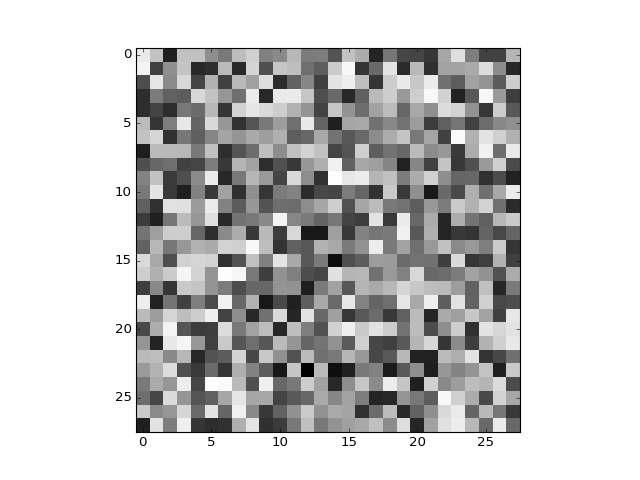

<IPython.core.display.Javascript object>


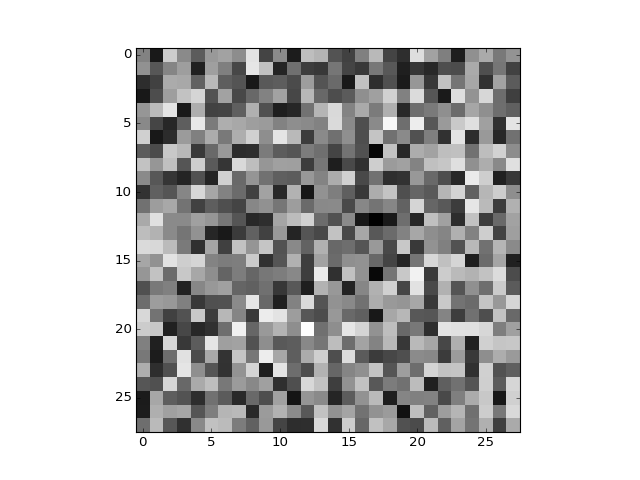

In [118]:
for i in xrange(10):
    f = w_[:, i].reshape(28, 28)
    
    plt.figure()
    plt.imshow(f, interpolation='none', cmap=plt.cm.gray_r)
    plt.show()

In [ ]:
p